In [1]:
# -*- coding: utf-8 -*-
import utils as utils

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Flatten, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import numpy as np
import os

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
import logging

logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [2]:
all_teachers=3
teacher_id = 3
epochs = 175
shot = 10
SIAMESE_MODEL_NAME = '..\scripts\models_h5\siamese_network2c-t{}_{}notebook.h5'.format(teacher_id,shot)
EMBEDDING_MODEL_NAME = 'embedding_network2w_0801.h5'
if os.path.exists(SIAMESE_MODEL_NAME):
    os.remove(SIAMESE_MODEL_NAME)

In [3]:
base_dir = r"F:\chest project dataset\dataset"
dataset_path = os.path.join( r"F:\chest project dataset\auto_datasets", r"auto_t{}_{}\t{}-{}".format(all_teachers,shot,teacher_id, shot))
result_file_path = os.path.join(base_dir, r"true_result_xlsx")
pre_results_path = os.path.join(base_dir, r"teacher_results_xlsx","result_{}_{}".format(all_teachers,shot))
train_image_list, train_y_list = utils.load_images(dataset_path, 'train', (100, 100))
print("The train set contains", len(train_image_list))

Found 20 images belonging to 2 classes.
The train set contains 20


In [4]:
test_path = r"F:\chest project dataset\dataset\pretrain_2c_0727"
valid_image_list, valid_y_list = utils.load_images(test_path, 'valid', (100, 100))
print("The valid set contains", len(valid_image_list))

Found 1200 images belonging to 2 classes.
The valid set contains 1200


In [5]:
test_image_list, test_y_list = utils.load_images(test_path, 'test', (100, 100))
print("The test set contains", len(test_image_list))

Found 1200 images belonging to 2 classes.
The test set contains 1200


In [6]:
# make train pairs
pairs_train, labels_train, source_labels_train, true_labels_train = utils.make_pairs(train_image_list, train_y_list)

# make validation pairs
pairs_val, labels_val, source_labels_val, true_labels_val = utils.make_pairs(valid_image_list, valid_y_list)

# make validation pairs
pairs_test, labels_test, source_labels_test, true_labels_test = utils.make_pairs(test_image_list, test_y_list)

num_classes: 2
num_classes: 2
num_classes: 2


In [7]:
import pandas as pd

In [8]:
x_train_1 = pairs_train[:, 0]  # x1(如何给标签带上)
x_train_2 = pairs_train[:, 1]  # x2
print("number of pairs for train", np.shape(x_train_1)[0])

x_val_1 = pairs_val[:, 0]
x_val_2 = pairs_val[:, 1]
print("number of pairs for validation", np.shape(x_val_1)[0])

x_test_1 = pairs_test[:, 0]
x_test_2 = pairs_test[:, 1]
# print(x_test_1)
print("number of pairs for test", np.shape(x_test_1)[0])

number of pairs for train 40
number of pairs for validation 2400
number of pairs for test 2400


In [9]:
if not os.path.exists(result_file_path):
    os.makedirs(result_file_path)
result_xlsx=os.path.join(result_file_path,"true_labels.xlsx")
if not os.path.exists(result_xlsx):
    test_1_image_list = x_test_1.tolist()
    df = pd.DataFrame({"image": test_1_image_list, "true_label": true_labels_test})
    df.to_excel(result_xlsx, index=False)
    df = pd.read_excel(result_xlsx)
    df.drop_duplicates(inplace=True)
    df.to_excel(result_xlsx, index=False)

In [10]:
tf.compat.v1.reset_default_graph()

input_1 = Input((100, 100, 3))
input_2 = Input((100, 100, 3))

embedding_network = tf.keras.models.load_model(EMBEDDING_MODEL_NAME)
embedding_network.trainable = False

model = tf.keras.Sequential()
for layer in embedding_network.layers:
    model.add(layer)

model.add(Flatten(name='flat'))
model.add(Dense(5120, name='den', activation='sigmoid', kernel_regularizer='l2'))

output_1 = model(input_1)
output_2 = model(input_2)

merge_layer = Lambda(utils.manhattan_distance)([output_1, output_2])
output_layer = Dense(1, activation="sigmoid")(merge_layer)
siamese = Model(inputs=[input_1, input_2], outputs=output_layer)
siamese.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 5120)         14739266    ['input_1[0][0]',                
                                                                  'input_2[0][0]']            

In [11]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, min_delta=0.0001)

checkpointer = ModelCheckpoint(filepath=SIAMESE_MODEL_NAME, verbose=1,
                               save_best_only=True)

In [12]:
optimizer = Adam(learning_rate=0.0001)
siamese.compile(loss=utils.loss(1), optimizer=optimizer, metrics=["accuracy"])
# siamese.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])

siamese.summary()
history = siamese.fit([x_train_1, x_train_2],
                      labels_train,
                      validation_data=([x_val_1, x_val_2], labels_val),
                      batch_size=1,
                      epochs=epochs,  # 175 for contrastive 100 for cross ent
                      callbacks=[checkpointer, early_stopping, reduce_lr]
                      )
# print()
# Plot the accuracy
# utils.plt_metric(history=history.history, metric="accuracy", title="Model accuracy")

# Plot the constrastive loss
# utils.plt_metric(history=history.history, metric="loss", title="Constrastive Loss")

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 5120)         14739266    ['input_1[0][0]',                
                                                                  'input_2[0][0]']            

Epoch 18/175
40/40 [==============================] - ETA: 0s - loss: 0.1533 - accuracy: 0.8500
Epoch 00018: val_loss improved from 0.20436 to 0.20370, saving model to ..\scripts\models_h5\siamese_network2c-t3_10notebook.h5
40/40 [==============================] - 393s 10s/step - loss: 0.1533 - accuracy: 0.8500 - val_loss: 0.2037 - val_accuracy: 0.6950 - lr: 1.0000e-04
Epoch 19/175
40/40 [==============================] - ETA: 0s - loss: 0.1524 - accuracy: 0.8500
Epoch 00019: val_loss improved from 0.20370 to 0.20262, saving model to ..\scripts\models_h5\siamese_network2c-t3_10notebook.h5
40/40 [==============================] - 395s 10s/step - loss: 0.1524 - accuracy: 0.8500 - val_loss: 0.2026 - val_accuracy: 0.6979 - lr: 1.0000e-04
Epoch 20/175
40/40 [==============================] - ETA: 0s - loss: 0.1513 - accuracy: 0.8500
Epoch 00020: val_loss did not improve from 0.20262
40/40 [==============================] - 395s 10s/step - loss: 0.1513 - accuracy: 0.8500 - val_loss: 0.2031 -

40/40 [==============================] - ETA: 0s - loss: 0.1362 - accuracy: 0.9500
Epoch 00041: val_loss improved from 0.19479 to 0.19419, saving model to ..\scripts\models_h5\siamese_network2c-t3_10notebook.h5
40/40 [==============================] - 397s 10s/step - loss: 0.1362 - accuracy: 0.9500 - val_loss: 0.1942 - val_accuracy: 0.7483 - lr: 1.0000e-04
Epoch 42/175
40/40 [==============================] - ETA: 0s - loss: 0.1355 - accuracy: 0.9500
Epoch 00042: val_loss improved from 0.19419 to 0.19396, saving model to ..\scripts\models_h5\siamese_network2c-t3_10notebook.h5
40/40 [==============================] - 396s 10s/step - loss: 0.1355 - accuracy: 0.9500 - val_loss: 0.1940 - val_accuracy: 0.7500 - lr: 1.0000e-04
Epoch 43/175
40/40 [==============================] - ETA: 0s - loss: 0.1350 - accuracy: 0.9500
Epoch 00043: val_loss improved from 0.19396 to 0.19340, saving model to ..\scripts\models_h5\siamese_network2c-t3_10notebook.h5
40/40 [==============================] - 396s

Epoch 65/175
40/40 [==============================] - ETA: 0s - loss: 0.1245 - accuracy: 1.0000
Epoch 00065: val_loss did not improve from 0.18713
40/40 [==============================] - 398s 10s/step - loss: 0.1245 - accuracy: 1.0000 - val_loss: 0.1880 - val_accuracy: 0.7696 - lr: 1.0000e-04
Epoch 66/175
40/40 [==============================] - ETA: 0s - loss: 0.1241 - accuracy: 1.0000
Epoch 00066: val_loss improved from 0.18713 to 0.18677, saving model to ..\scripts\models_h5\siamese_network2c-t3_10notebook.h5
40/40 [==============================] - 395s 10s/step - loss: 0.1241 - accuracy: 1.0000 - val_loss: 0.1868 - val_accuracy: 0.7708 - lr: 1.0000e-04
Epoch 67/175
40/40 [==============================] - ETA: 0s - loss: 0.1237 - accuracy: 1.0000
Epoch 00067: val_loss did not improve from 0.18677
40/40 [==============================] - 396s 10s/step - loss: 0.1237 - accuracy: 1.0000 - val_loss: 0.1869 - val_accuracy: 0.7708 - lr: 1.0000e-04
Epoch 68/175
40/40 [==================

Epoch 90/175
40/40 [==============================] - ETA: 0s - loss: 0.1146 - accuracy: 1.0000 ETA
Epoch 00090: val_loss did not improve from 0.18120
40/40 [==============================] - 403s 10s/step - loss: 0.1146 - accuracy: 1.0000 - val_loss: 0.1818 - val_accuracy: 0.7879 - lr: 1.0000e-04
Epoch 91/175
40/40 [==============================] - ETA: 0s - loss: 0.1142 - accuracy: 1.0000
Epoch 00091: val_loss improved from 0.18120 to 0.18098, saving model to ..\scripts\models_h5\siamese_network2c-t3_10notebook.h5
40/40 [==============================] - 428s 11s/step - loss: 0.1142 - accuracy: 1.0000 - val_loss: 0.1810 - val_accuracy: 0.7896 - lr: 1.0000e-04
Epoch 92/175
40/40 [==============================] - ETA: 0s - loss: 0.1139 - accuracy: 1.0000
Epoch 00092: val_loss improved from 0.18098 to 0.18060, saving model to ..\scripts\models_h5\siamese_network2c-t3_10notebook.h5
40/40 [==============================] - 416s 11s/step - loss: 0.1139 - accuracy: 1.0000 - val_loss: 0.18

40/40 [==============================] - ETA: 0s - loss: 0.1059 - accuracy: 1.0000 ETA: 1s - loss: 0.118
Epoch 00115: val_loss improved from 0.17695 to 0.17674, saving model to ..\scripts\models_h5\siamese_network2c-t3_10notebook.h5
40/40 [==============================] - 392s 10s/step - loss: 0.1059 - accuracy: 1.0000 - val_loss: 0.1767 - val_accuracy: 0.7983 - lr: 2.0000e-05
Epoch 116/175
40/40 [==============================] - ETA: 0s - loss: 0.1058 - accuracy: 1.0000
Epoch 00116: val_loss did not improve from 0.17674
40/40 [==============================] - 395s 10s/step - loss: 0.1058 - accuracy: 1.0000 - val_loss: 0.1768 - val_accuracy: 0.7983 - lr: 2.0000e-05
Epoch 117/175
40/40 [==============================] - ETA: 0s - loss: 0.1058 - accuracy: 1.0000
Epoch 00117: val_loss improved from 0.17674 to 0.17607, saving model to ..\scripts\models_h5\siamese_network2c-t3_10notebook.h5
40/40 [==============================] - 390s 10s/step - loss: 0.1058 - accuracy: 1.0000 - val_los

40/40 [==============================] - ETA: 0s - loss: 0.1047 - accuracy: 1.0000
Epoch 00140: val_loss did not improve from 0.17522
40/40 [==============================] - 219s 6s/step - loss: 0.1047 - accuracy: 1.0000 - val_loss: 0.1754 - val_accuracy: 0.8004 - lr: 1.0000e-05
Epoch 141/175
40/40 [==============================] - ETA: 0s - loss: 0.1047 - accuracy: 1.0000
Epoch 00141: val_loss did not improve from 0.17522
40/40 [==============================] - 213s 5s/step - loss: 0.1047 - accuracy: 1.0000 - val_loss: 0.1753 - val_accuracy: 0.8008 - lr: 1.0000e-05
Epoch 142/175
40/40 [==============================] - ETA: 0s - loss: 0.1046 - accuracy: 1.0000
Epoch 00142: val_loss did not improve from 0.17522
40/40 [==============================] - 213s 5s/step - loss: 0.1046 - accuracy: 1.0000 - val_loss: 0.1754 - val_accuracy: 0.8004 - lr: 1.0000e-05
Epoch 143/175
40/40 [==============================] - ETA: 0s - loss: 0.1046 - accuracy: 1.0000
Epoch 00143: val_loss did not im

In [13]:
results = siamese.evaluate([x_test_1, x_test_2], labels_test)
print("test loss, test acc:", results)

75/75 [==============================] - 164s 2s/step - loss: 0.1214 - accuracy: 0.9479
test loss, test acc: [0.12137705832719803, 0.9479166865348816]


In [14]:
Y_pred = siamese.predict([x_test_1, x_test_2]).squeeze()
# 返回的是TRUE或FALSE,没有标签数据怎么知道他被分到哪儿个类中？
y_pred = Y_pred > 0.5
# x1,和x2是否匹配：匹配1，不匹配0
y_test = labels_test
print("\nEvaluate on validation data")
Accuracy=accuracy_score(y_test, y_pred)
Precision=precision_score(y_test, y_pred, average='weighted')
Recall=recall_score(y_test, y_pred, average='weighted')
ROC_AUC=roc_auc_score(y_test, y_pred, average='weighted')
F1=f1_score(y_test, y_pred, average='weighted')
print("Accuracy:", Accuracy)
print("Precision:", Precision)
print("Recall:", Recall)
print("ROC AUC:", ROC_AUC)
print("F1:",F1 )


Evaluate on validation data
Accuracy: 0.9479166666666666
Precision: 0.9522155406499705
Recall: 0.9479166666666666
ROC AUC: 0.9479166666666667
F1: 0.9477925924997794


In [15]:
y_pred = [1 if i else 0 for i in y_pred]
pred_labels = []

for i in range(0, len(y_pred)):
    if y_pred[i] == 1:
        pred_labels += [source_labels_test[i]]
    else:
        if source_labels_test[i] == 1:
            pred_labels += [0.0]
        else:
            pred_labels += [1.0]
a = x_test_1.tolist()
df = pd.DataFrame({"image": a, "label_{}".format(teacher_id): pred_labels})
if not os.path.exists(pre_results_path):
    os.makedirs(pre_results_path)
df.to_excel(os.path.join(pre_results_path,"{}_{}_{}.xlsx".format(epochs,teacher_id,shot)),index=False)

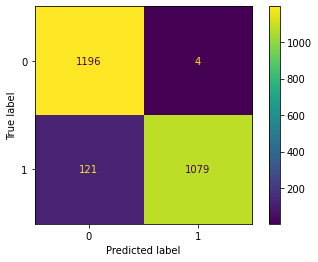

Specificity: 0.9966666666666667


In [16]:
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()
plt.show()
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
print("Specificity:", specificity)
data_list=[{"Accuracy":Accuracy,"Precision":Precision,"Recall":Recall,"ROC_AUC":ROC_AUC,"tn":tn,"fp":fp,"fn":fn,"tp":tp,"specificity":specificity}]
df=pd.DataFrame(data_list)

filepath=os.path.join(base_dir,r"acc_{}_{}".format(all_teachers,shot))
if not os.path.exists(filepath):
    os.mkdir(filepath)
df.to_excel(os.path.join(filepath,"{}_{}.xlsx".format(teacher_id,shot)),index=False)
tf.keras.backend.clear_session()